# PZ-model

## Model

(Using the same Fourier transform convention as in allpole.ipynb.)

Impulse response for $K$ poles $p_k = -\pi y_k + 2\pi i x_k$ has the same form as an AP (all-pole) model:

$$ h(t; p) = (t \geq 0) \times \sum_{k=1}^K c_k e^{p_k t} + c_k^* e^{p_k^* t}$$

But now each coefficient $c_k$ is determined by 2 free parameters $(a_k,b_k) \in \mathbb{R}$:

$$ c_k = {a_k - ib_k \over 2} \iff (a_k = c_k + c_k^*, b_k = ic_k - ic_k^*)$$

such that

$$ c_k e^{p_k t} + c_k^* e^{p_k^* t} = (a_k \cos(2\pi i x_k) + b_k \sin(2\pi i x_k)) \exp(-\pi y_k t) $$

The transfer function follows immediately from the form of the impulse response $h(t; p)$:

$$ \tilde{h}(x; p) = \sum_{k=1}^K {c_k \over 2\pi i x - p_k} + {c_k^* \over 2\pi i x - p_k^*} $$

[Note that the AP model can also be written in this way, but the expression for $c_k$ is more involved (the excluded pole product).]

In this form it is easy to see that the analytical spectral tilt at $x \rightarrow \infty$ should be about -6 dB/oct, independent of $K$, since $\tilde{h}(\infty, p) \propto 1/x$. Ofcourse the amplitudes can conspire in such ways that, e.g., the model collapses to an AP model with characteristic $(-12K)$ dB/oct tilt.

Collecting the terms, we get a proper transfer function in rational form:

$$ \tilde{h}(x; p) = {N(2\pi i x) \over \prod_{k=1}^K (2\pi i x - p_k)(2\pi i x - p_k^*)}$$

where $N(2\pi i x)$ is a polynomial of degree at most $2K - 1$.

## Normalization

If we adapt the same normalization as the AP, i.e., $\tilde{h}(0; p) := 1$, we would have to divide $\tilde{h}(x; p)$ **and $h(t; p)$** by the following factor:

$$DC = -2 \sum_{k=1}^K {Re(c_k p_k^*) \over |p_k|^2}$$

However, doing this would stop $h(t; p)$ from being purely linear in the amplitudes (since $DC$ depends on $c_k = {a_k - ib_k \over 2}$) and this is counterproductive; much better to normalize implicitly using the ME prior that yields a MVN over $(a,b)$ directly. Below we show that this yields superior normalization compared to AP -- it yields impulse responses $h(t; p)$ whose peak amplitudes are O(1), just what we like because our data peak amplitude is O(2) and our source DGF peak amplitude is O(5).

## Comparison with AP model

Disadvantages:
- Twice as much parameters: $(4K)$ (PZ) instead of $(2K)$ (AP)

Advantages:
- Automatically regularizes itself ("nested model")
- Can model more realistic spectral tilt
- Easier normalization such that the peak amplitudes of the impulse response $h$ are O(1) using our ME prior
- Can model zeros more easier
- Independent amplitudes of the formant peaks, which seems intuitively desirable

In [1]:
%run init.ipy

from vtr.prior import bandwidth
from dgf import core
from lib import constants
from vtr.prior import allpole
from vtr import spectrum

from vtr.prior import polezero

2022-11-26 13:27:30.762532: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory


## The amplitude prior

[Based on: von der Linden (2014) Eq. (21.67) p. 348-349]

The impulse response is just a basis function expansion with $E=2K$ terms with amplitudes $a_k, b_k$:
$$ \begin{align}
h(t; p) &= (t \geq 0) \times \sum_{k=1}^K c_k e^{p_k t} + c_k^* e^{p_k^* t} \\
&= (t \geq 0) \times \sum_{k=1}^K (a_k \cos(2\pi i x_k) + b_k \sin(2\pi i x_k)) \exp(-\pi y_k t) \\
&= \sum_{i=1}^{E=2K} \alpha_i \phi_i(t)
\end{align}$$
where $(\alpha_i = a_i \text{ if $i \leq K$ else } b_{i-K})$ and we tried to follow the notation of von der Linden.

So we can assign a prior to the amplitudes based on the energy (wrongly called $P(a)$ suggesting power -- but power needs to be divided by time) of the impulse response:
$$
\mathcal{E}(\alpha) = \int dt h(t; p)^2 = \sum_{ij=1}^E a_i a_j S_{ij} = \mu^2
$$
Here $S_{ij}$ is the overlap matrix which can be calculated analytically.
Similar calculations are done in @Bretthorst1991 in the discrete time domain, but our continous formulation (the $\int$ instead of $\sum$) allows for efficient close-form formulas. These are given in `vtr/overlapmatrix.nb`. Then the MVN prior for the amplitudes given the poles $p$ is
$$ p(a|p,\mu^2) = MVN(0, \Sigma) $$ where $$ \Sigma = {\mu^2 \over 2K} S(p)^{-1}$$.

Note that $S_{ij}$ and $\mu^2$ have dimensions of time. In our case we assign $\mu^2 = O(1) = 1\ msec$.
Why?
The normalized-to-unit-power speech data has typical peak amplitude O(2).
The source prior typically yields O(5) peak amplitude in DGF waveform.
Therefore we want our impulse response $h(t)$ to have O(1) peak amplitude.
This is well accomplished by setting $\mu^2 = 1\ msec$.

(This is an example of why it is good to work in a scale where things are O(1), so that O(1) guesses for parameter are likely to succeed without putting any though in it.)

In [2]:
def samplexy(K = 3, prior = bandwidth.TFB_prior()):
    T, *xy = prior.sample(seed=jaxkey())
    x, y = np.split(np.array(xy), 2)
    x, y = x[:K], y[:K]
    return x, y

def eval_G(t, x, y):
    K = len(x)
    G = np.empty((len(t), 2*K))
    X, Y, T = x[None,:], y[None,:], t[:,None]
    
    G[:, :K] = np.cos(2.*np.pi*X*T)*np.exp(-np.pi*Y*T)
    G[:, K:] = np.sin(2.*np.pi*X*T)*np.exp(-np.pi*Y*T)
    return G # (N, m)

[Memory]6.9s, 0.1min    : Loading get_vtrformants_training_data...


[Memory]7.4s, 0.1min    : Loading run_nested...
[Memory]8.6s, 0.1min    : Loading run_nested...


4.080194671074122

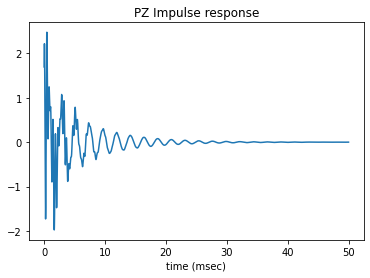

In [254]:
K = 3
x, y = samplexy(K)

fs = 1000 # kHz
dt = 1/fs # msec
t = np.arange(0., 50, dt) # msec
G = eval_G(t, x/1000, y/1000)

ab = polezero.amplitudes_prior_ppf(rand(2*K), x, y)

s = G @ ab
plot(t, s)
title("PZ Impulse response")
xlabel("time (msec)")
mu2 = np.dot(s, s)*dt
mu2

Test if the expected values $<\mu^2>$ is close to its prescribed value (1 msec):

1.0170588948411352

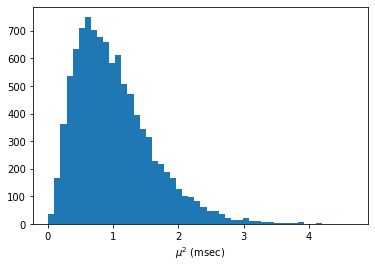

In [4]:
mu2s = []
for _ in range(10000):
    a = polezero.amplitudes_prior_ppf(rand(2*K), x, y)
    s = G @ a
    mu2 = np.dot(s, s)*dt
    mu2s += [mu2]

hist(mu2s, bins=50)
xlabel("$\mu^2$ (msec)")
mean(mu2s) # msec

## Check power spectrum

-5.476144640199565

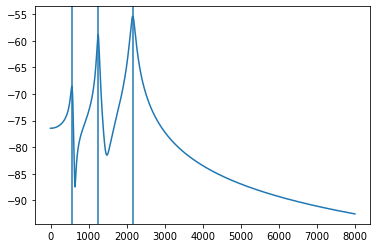

In [268]:
K = 3
x, y = samplexy()

ab = polezero.amplitudes_prior_ppf(rand(2*K), x, y)
f = constants.spectrum_frequencies(constants.TIMIT_FS_HZ)
power = polezero.transfer_function_power_dB(f, x, y, ab)
plot(f, power)
for xi in x: axvline(xi)
spectrum.fit_tilt(f, power)

### AP model as a special case of PZ

The PZ model includes the AP model as a special case, when the amplitudes $(a,b)$ take on specific values:

[-0.04497065  0.11639943 -0.07142877  5.45013949 -3.45729637  1.03882468]


-24.598440382945657

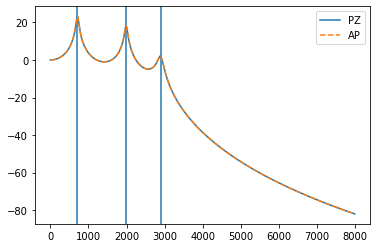

In [264]:
K = 3
x, y = samplexy(K)

# Calculate the amplitudes that turn the PZ into an AP
poles = core.make_poles(y, x)
c = core.pole_coefficients(poles)
a = real(c + conj(c))
b = real((1j)*(c - conj(c)))
ab_AP = np.concatenate((a, b))
print(ab_AP)

power = polezero.transfer_function_power_dB(f, x, y, ab_AP, normalize_gain=True)
plot(f, power, label="PZ")
for xi in x: axvline(xi)

plot(f, allpole.transfer_function_power_dB(f, x, y), '--', label="AP")
legend();

spectrum.fit_tilt(f, power)

But does the $p(a,b|p,\mu^2)$ prior place any mass at that specific point? **No.** We can check this in two ways:

1. Distribution of spectral tilt: tilt of 3-pole AP model is roughly -36 dB/oct, and this lies far away from the tilts of the PZ model

CPU times: user 1min 53s, sys: 63.6 ms, total: 1min 53s
Wall time: 1min 53s


-7.1221120435035115

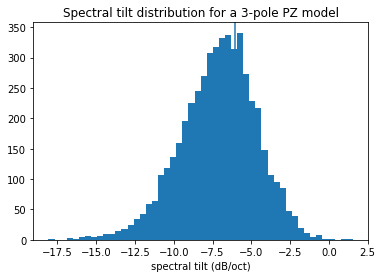

In [7]:
%%time
tilts = []

K = 3
f = constants.spectrum_frequencies(constants.TIMIT_FS_HZ)

for i in range(5000):
    x, y = samplexy()
    ab = polezero.amplitudes_prior_ppf(rand(2*K), x, y)
    power = polezero.transfer_function_power_dB(f, x, y, ab)
    
    F, B = spectrum.get_formants_from_spectrum(f, power)
    tilts += [spectrum.fit_tilt(f, power)]

hist(tilts, bins=50);
axvline(polezero.analytical_tilt())
title("Spectral tilt distribution generated by$ p(a,b|p,mu^2)$ for a 3-pole PZ model")
xlabel("spectral tilt (dB/oct)")
mean(tilts)

2. A direct check: where does the special point at which $(a,b) == $ `ab_AP` turn the PZ model into a "degenerate" AP model lie with respect to the distribution of the $(a,b)$ prior? Answer: far away. Blue points in the corner plot below: lie basically outside of the support of our ME prior for the $(a,b)$ amplitudes. And indeed, the typical peak amplitudes of the impulse response of the AP model are roughly 10x larger than those of the PZ model.

[ 7.88915564e-03  3.54786610e-04 -8.24394225e-03  3.42820664e+00
 -1.62539197e+00  2.43450412e-01]


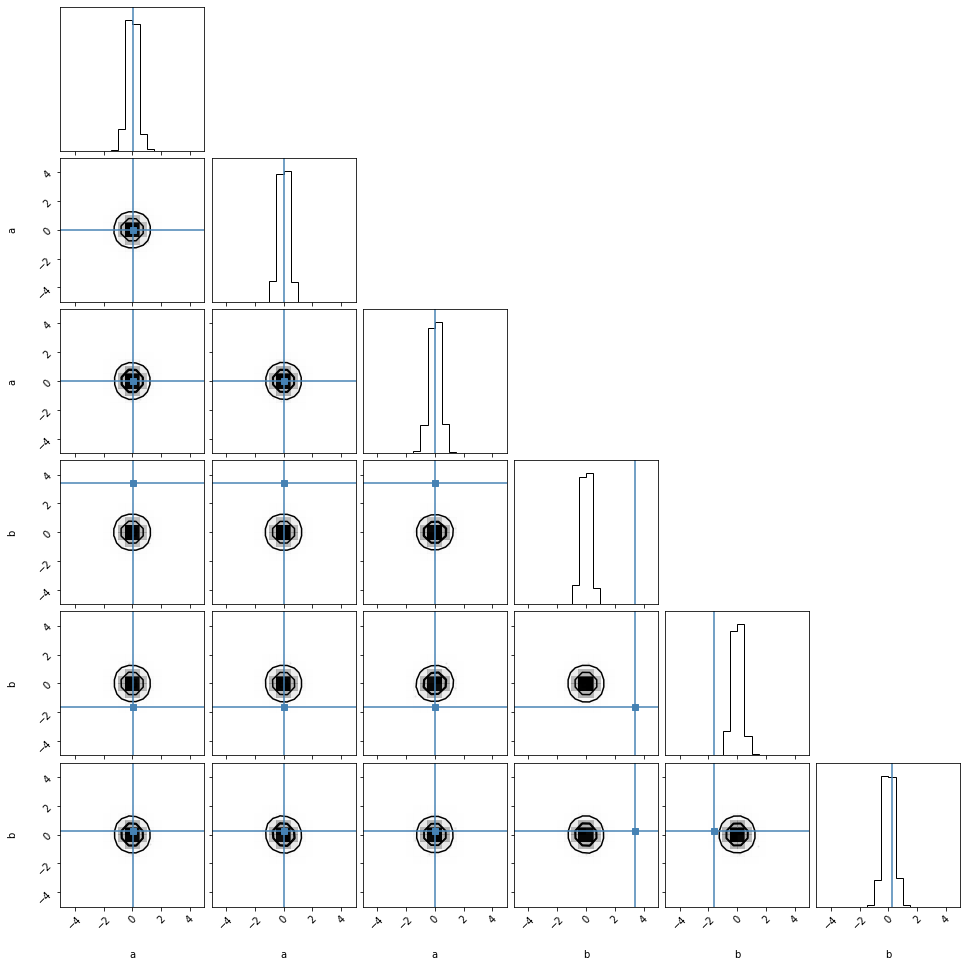

In [8]:
import corner
import itertools

print(ab_AP)

x, y = samplexy()
ab_samples = polezero.amplitudes_prior_ppf(rand(2*K, 1000), x, y).T

corner.corner(
    ab_samples,
    range = itertools.repeat((-5, 5), 2*K),
    labels = [*["a"]*K, *["b"]*K],
    smooth = 1.,
    truths = ab_AP
);

## Try a fit to a TFB sample

In [9]:
samples = bandwidth.get_TFB_samples()

[Memory]162.0s, 2.7min  : Loading get_TFB_samples...


In [11]:
fitted = polezero.get_fitted_TFB_samples()

[Memory]171.3s, 2.9min  : Loading get_TFB_samples...
[Memory]171.3s, 2.9min  : Loading run_nested...
[Memory]171.3s, 2.9min  : Loading run_nested...
[Memory]171.3s, 2.9min  : Loading run_nested...
[Memory]171.3s, 2.9min  : Loading run_nested...
[Memory]171.3s, 2.9min  : Loading run_nested...
[Memory]171.3s, 2.9min  : Loading run_nested...
[Memory]171.3s, 2.9min  : Loading run_nested...
[Memory]171.3s, 2.9min  : Loading run_nested...
[Memory]171.3s, 2.9min  : Loading run_nested...
[Memory]171.3s, 2.9min  : Loading run_nested...
[Memory]171.3s, 2.9min  : Loading run_nested...
[Memory]171.3s, 2.9min  : Loading run_nested...
[Memory]171.3s, 2.9min  : Loading run_nested...
[Memory]171.3s, 2.9min  : Loading run_nested...
[Memory]171.4s, 2.9min  : Loading run_nested...
[Memory]171.4s, 2.9min  : Loading run_nested...
[Memory]171.4s, 2.9min  : Loading run_nested...
[Memory]171.4s, 2.9min  : Loading run_nested...
[Memory]171.4s, 2.9min  : Loading run_nested...
[Memory]171.4s, 2.9min  : Loading r

In [143]:
K = 4
sample_index = 40

def getfit(K, sample_index):
    return fitted[(K-3)*50+sample_index]

fit = getfit(K, sample_index)

sample = fit['sample']
results = fit['results']

Summary
nlive: 48
niter: 1114
ncall: 127009
eff(%):  0.915
logz: -20.608 +/-  0.645


None

'Information (bans)'

7.594928557373848

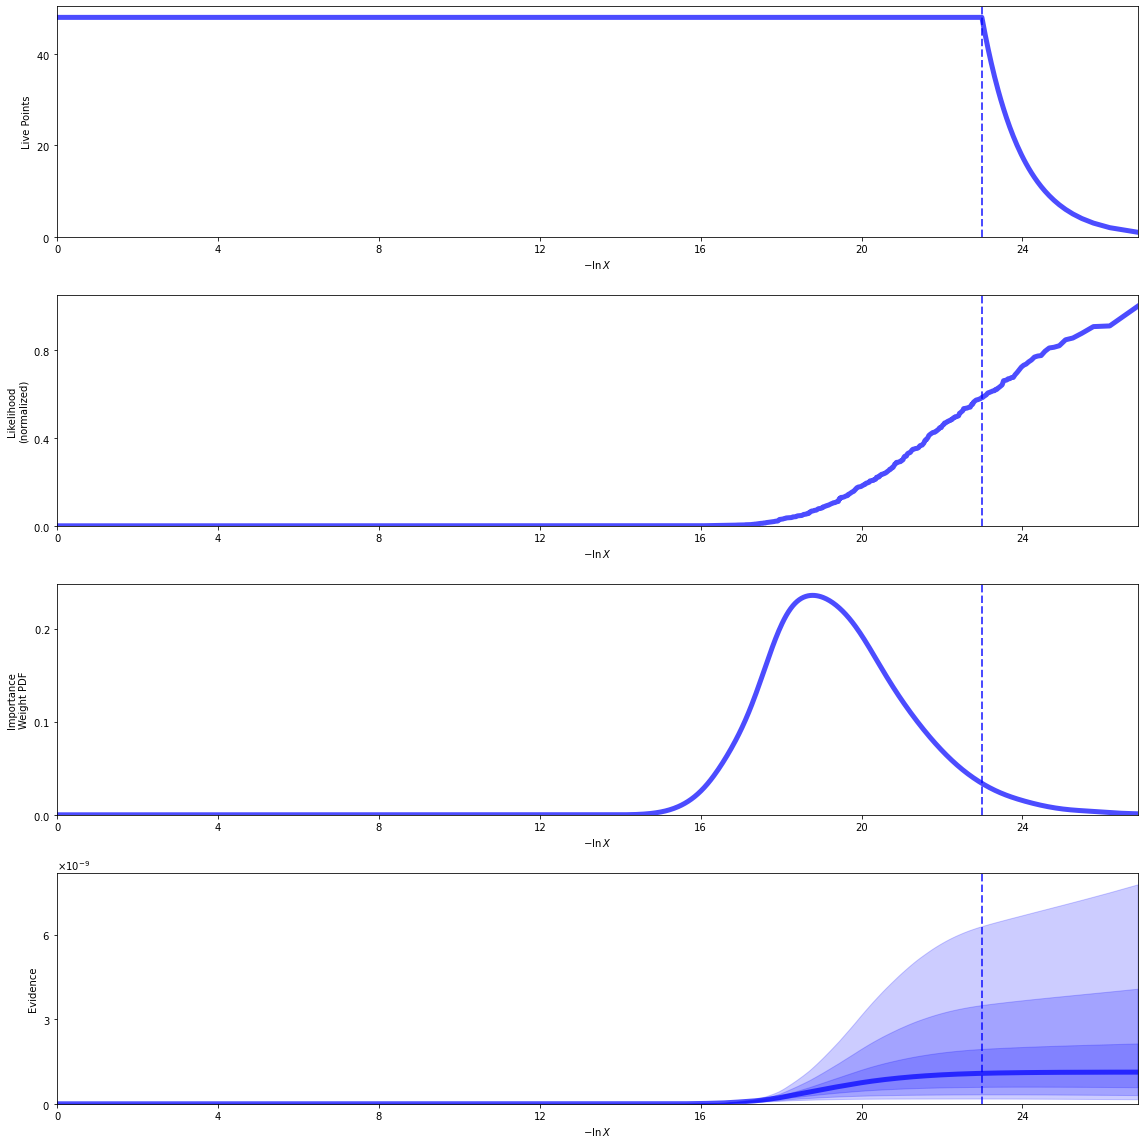

Quantiles:
x [(0.025, 397.865483249194), (0.5, 414.62848414604827), (0.975, 430.1513653270574)]
Quantiles:
x [(0.025, 430.2037088378997), (0.5, 497.77559008236045), (0.975, 532.4663897315149)]
Quantiles:
x [(0.025, 2433.629470966615), (0.5, 2455.4028874531537), (0.975, 2482.568482422845)]
Quantiles:
x [(0.025, 2786.6592597864023), (0.5, 2853.6591511235497), (0.975, 2923.5062003396743)]
Quantiles:
y [(0.025, 55.72754063865219), (0.5, 90.26789032436244), (0.975, 130.6379900099402)]
Quantiles:
y [(0.025, 43.47903517125095), (0.5, 308.49503409893634), (0.975, 2231.9965573584004)]
Quantiles:
y [(0.025, 118.37297609501474), (0.5, 157.87199987976996), (0.975, 212.58564287439373)]
Quantiles:
y [(0.025, 24.0419852596201), (0.5, 123.44308346741913), (0.975, 372.6717039684307)]
Quantiles:
a [(0.025, -0.011510474601220833), (0.5, 0.36385038186945956), (0.975, 0.924824211211952)]
Quantiles:
a [(0.025, -1.5670310113248833), (0.5, -0.3567762046260994), (0.975, 0.9550726238104665)]
Quantiles:
a [(0.02

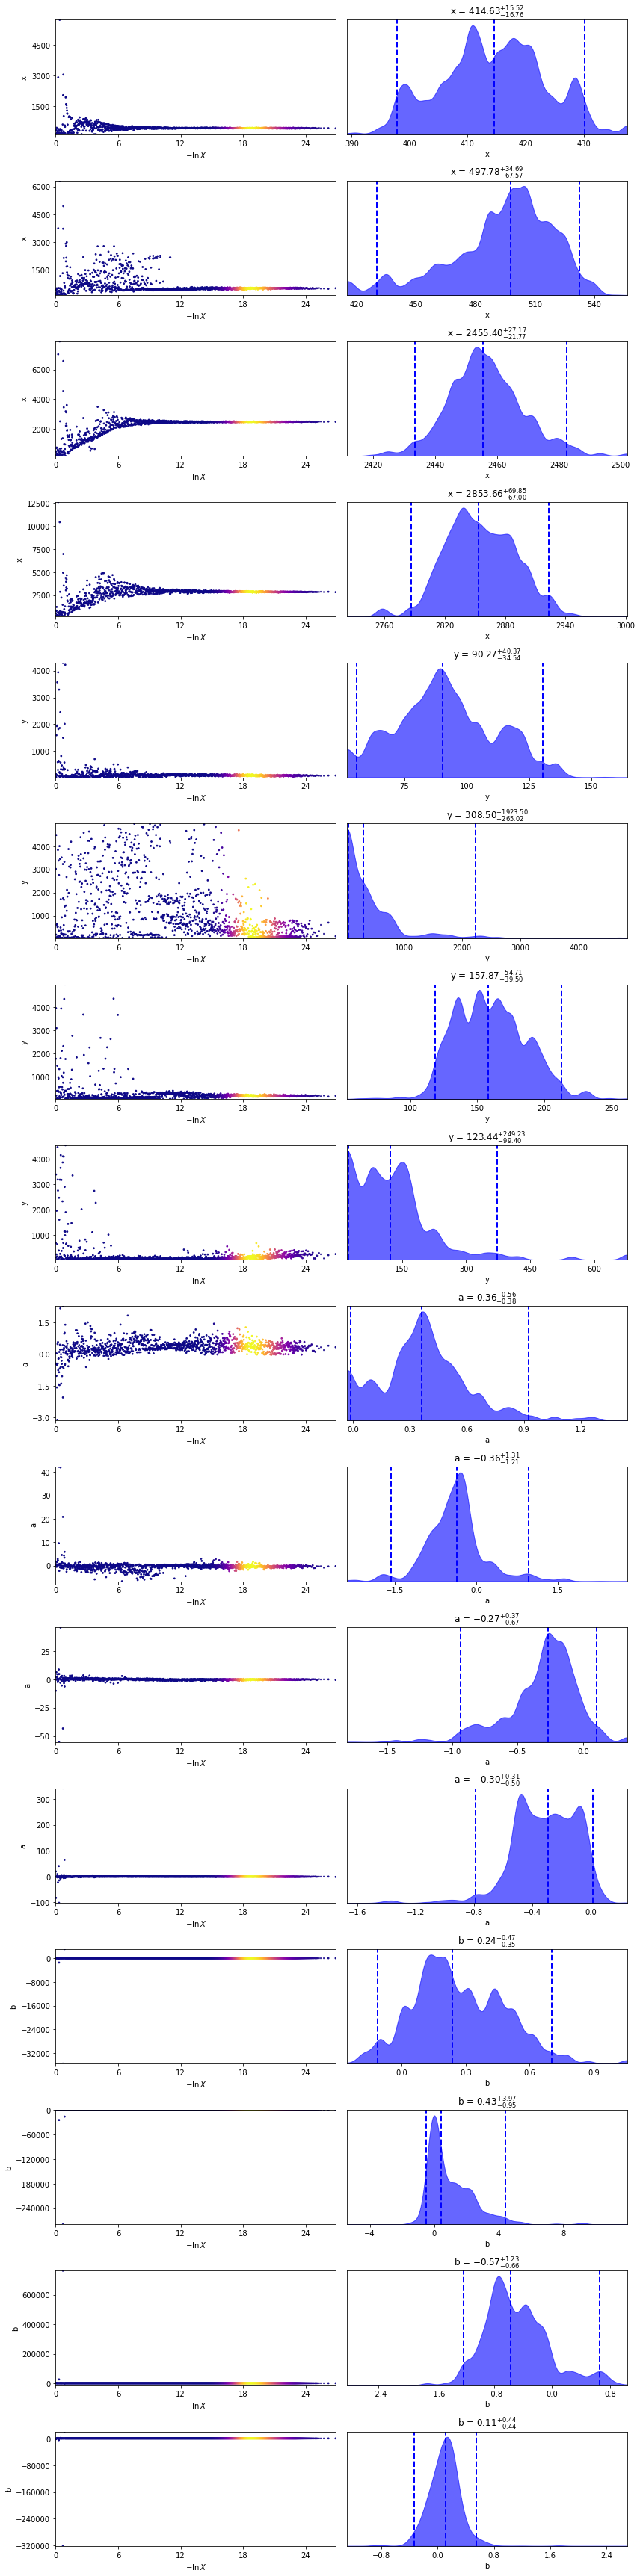

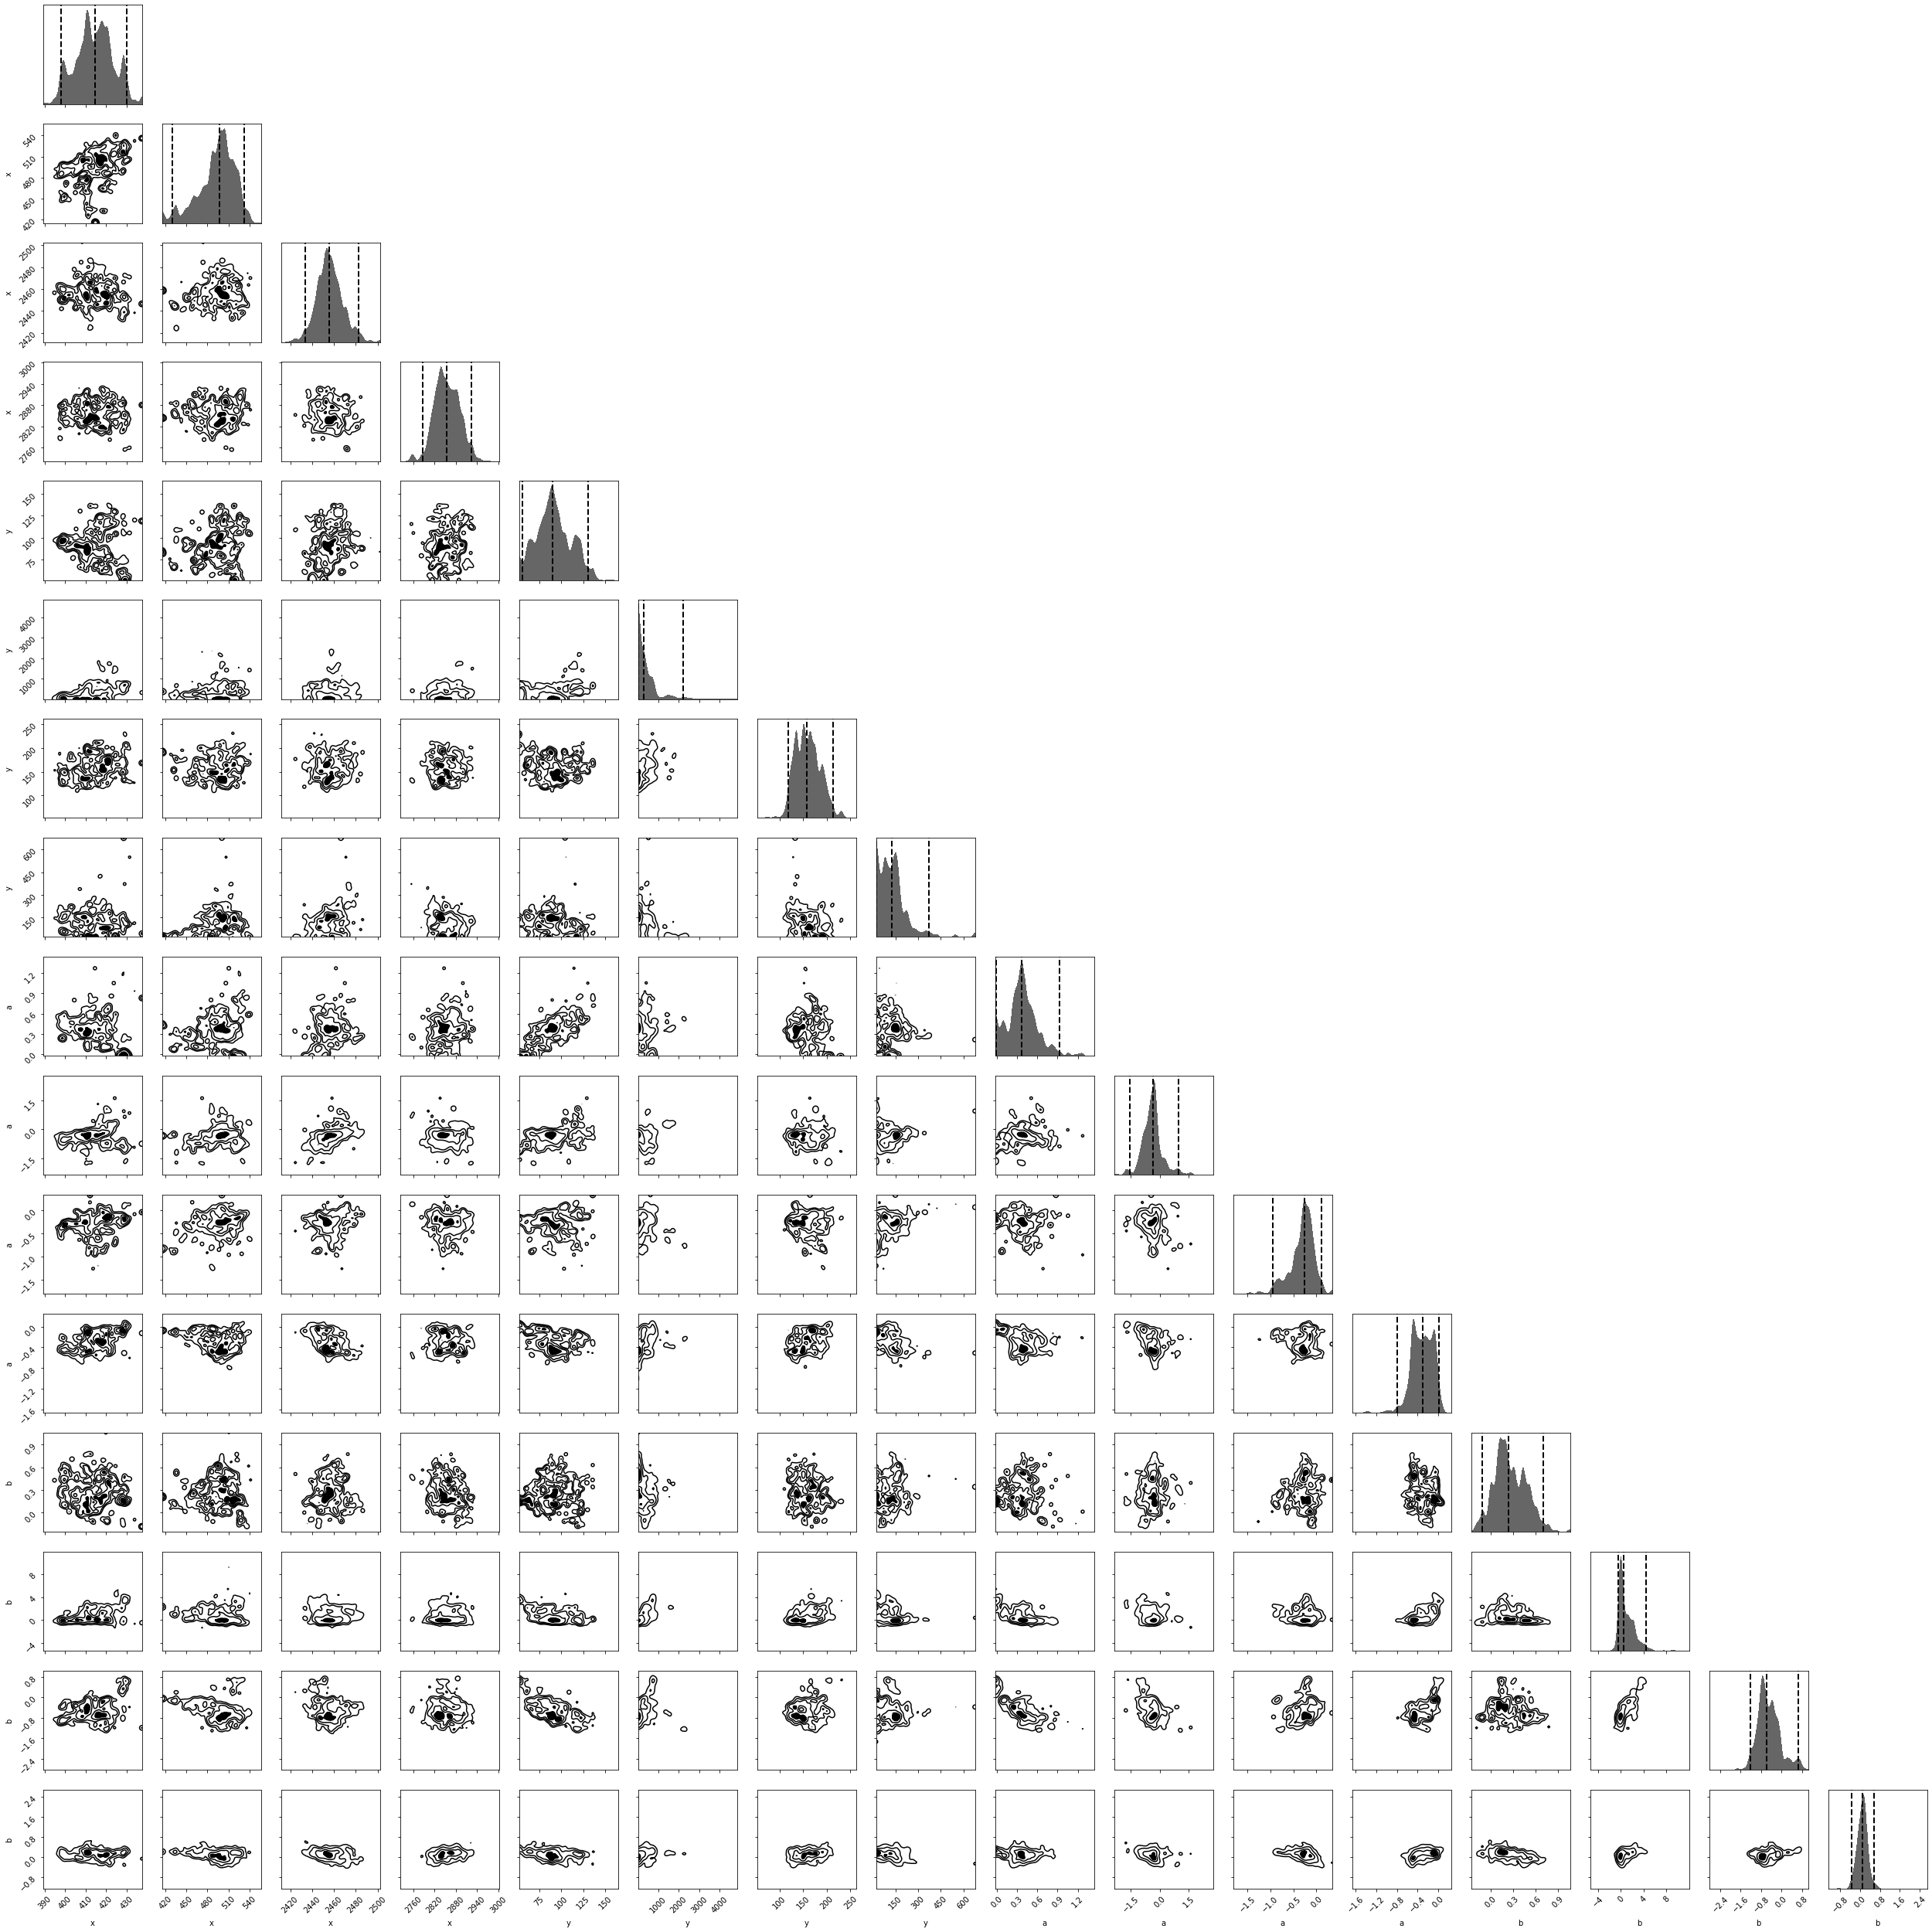

In [144]:
from lib import util
util.dyplot(results, (*["x"]*K, *["y"]*K, *["a"]*K, *["b"]*K))

-5.505904890203559 -6.020599913279624
0.14785621698919202 5.314374231140651 0.1920526421742692
-8.106408130216943 -6.020599913279624
4.343307458891488 5.864515622065864 0.582628441449681
-6.646336403478938 -6.020599913279624
4.115679644591352 7.027934911659856 0.3373194058483374


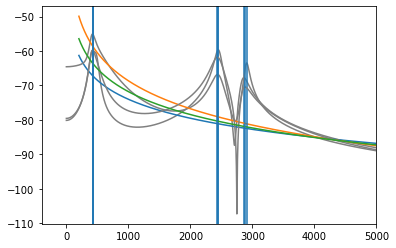

In [148]:
from vtr.prior.polezero import *

def unpack(params):
    xy, ab = np.split(params, 2)
    x, y = np.split(xy, 2)
    return x, y, ab

def loglike_debug(
    params,
    f = sample['f'][::2],
    F_true = sample['F'],
    B_true = sample['B'],
    sigma_F = np.array([2., 7, 29]),
    sigma_B = np.array([4., 14, 58]),
    tilt_target = constants.FILTER_SPECTRAL_TILT_DB,
    sigma_tilt = constants.SIGMA_TILT_DB
):
    x, y, ab = unpack(params)
    
    power = transfer_function_power_dB(f, x, y, ab)
    plot(f, power, "grey")

    # Heuristically measure formants
    try:
        F, B = spectrum.get_formants_from_spectrum(f, power)
    except np.linalg.LinAlgError:
        return -np.inf

    if len(F) != 3:
        return -np.inf

    # Heuristically measure spectral tilt
    tilt = spectrum.fit_tilt(f, power)

    tilt, interp = spectrum.fit_tilt(f, power, return_interp=True)
    print(tilt, polezero.analytical_tilt())
    
    plot(f[f > 200], interp(f[f > 200]))
    
    for Fi in F: axvline(Fi)
    
    F_err = np.sum(((F - F_true)/sigma_F)**2)
    B_err = np.sum(((B - B_true)/sigma_B)**2)
    tilt_err = ((tilt - tilt_target)/sigma_tilt)**2

    print(F_err, B_err, tilt_err)
    
    return -(F_err + B_err + tilt_err)/2

loglike_debug(util.resample_equal(results, 1).squeeze())
loglike_debug(util.resample_equal(results, 1).squeeze())
loglike_debug(util.resample_equal(results, 1).squeeze())
xlim(None, 5000);

-2.7239267790726913 -6.020599913279624
0.7110360013274999 0.32530414692510445 0.008188593460290019
-9.241993922167712 -6.020599913279624
0.06380204799555923 0.34797340918168407 0.8194761870111574


-0.6156258220942004

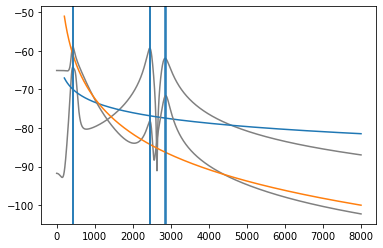

In [146]:
loglike_debug(results.samples[-1,:])
loglike_debug(results.samples[-2,:])


In [104]:
util.resample_equal(results, 5)

array([[ 4.43414964e+02,  6.53817113e+02,  1.38589007e+03,
         2.14922932e+03,  2.45813748e+03,  2.84799089e+03,
         1.14889968e+02,  3.45320490e+02,  7.76887529e+02,
         1.03964096e+03,  1.48163629e+02,  5.05645284e+01,
        -1.46858916e-01,  8.08890200e-01,  1.22188882e-01,
         8.23275787e-01, -6.31466875e-01, -6.92301670e-02,
         6.07929616e-01, -3.73316712e-01,  8.99201084e-01,
         3.99254086e+00, -3.08404702e+00, -1.43381244e+00],
       [ 4.48188829e+02,  6.92164632e+02,  1.42623341e+03,
         2.33474569e+03,  2.47676539e+03,  2.84924017e+03,
         9.49275134e+01,  1.20166836e+03,  1.19551169e+03,
         1.27306590e+03,  1.33472543e+02,  1.28794275e+02,
        -6.40284356e-02,  9.22851100e-01, -9.38924162e-02,
         4.10423189e-01, -2.29820751e-01, -2.46392894e-01,
         1.62654092e-01, -2.56320738e+00,  3.31675164e+00,
         2.89075012e+00, -2.05329606e+00, -3.12222010e+00],
       [ 4.44141304e+02,  7.73120727e+02,  1.50945766e

(array([ 455.13517727,  583.67525657,  797.09131673,  967.28593066,
        1249.90748549, 1541.17281178, 1554.18428727, 2016.64832186,
        3244.64968128, 3325.93488596]),
 array([ 996.41512644, 1007.51544477, 1033.38011636,  120.59833804,
        1162.52216461,  414.88160173,   42.04990911, 1355.38680225,
          85.235753  ,  243.57080257]),
 array([ 1.33122808e-01, -5.99633513e+00,  1.94101085e+01, -4.87417130e+00,
        -2.65660824e+01,  1.59739857e+01, -4.88688819e+00,  1.72575324e+01,
         1.56226979e-01,  1.08619368e+00, -6.10641594e+01,  1.61224065e+01,
         2.29073710e+02, -1.37745245e+02,  9.61144262e+01, -1.16652770e+02,
         2.74607884e+01, -4.59120706e+01,  1.06147461e+00, -1.56419107e+01]))

mu2(analytical) [msec] = 0.858031784777733
mu2 [msec] = 0.8589976515319294


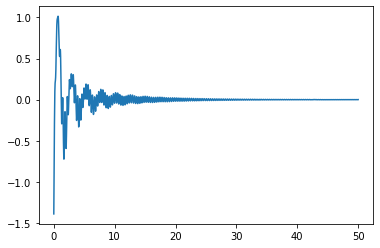

8.455469155964766e-07

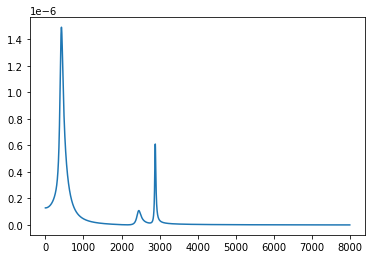

In [246]:
x, y, ab = unpack(util.resample_equal(results, 1).squeeze())

##

S = polezero.overlap_matrix(x, y)
mu2_analytical_sec = ab.T @ S @ ab
print("mu2(analytical) [msec] =", mu2_analytical_sec*1000)

##

fs = 1000 # kHz
dt = 1/fs # msec
t = np.arange(0., 50, dt) # msec
G = eval_G(t, x/1000, y/1000)

h = G @ ab
plot(t, h)

mu2 = np.dot(h, h)*dt
print("mu2 [msec] =", mu2)

##

f = sample['f']

power_db = polezero.transfer_function_power_dB(f, x, y, ab)
power = 10**(power_db/10)

show()
plot(f, power)

scipy.integrate.trapezoid(power, f)/1000*2 # sec/msec problem